<a href="https://colab.research.google.com/github/GSukr/Ensemble_CNN_Classification_with_Data_Augmentation/blob/master/generatedLabeledImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluating labeled images generated using Conditional Generative Adverserial Nets (CGAN)
- This notebook evaluates the quality of fake labeled images generated using CGAN
- CGAN implemetation used: https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py, but  this can be substituted for alternate implementations.

- Intrinsic measures that indicate high quality generated images:

1.   The predictive accuracy of the *discriminator* should approach ***0.5*** indicating that the generated images are indintinguishable from the real images.
2.   The (*binary cross-entropy*) loss of the *generator* as well as the  loss of the *discriminator*, approach *-log(0.5)*=***0.69***



- Extrinsic measures that indicate high quality generated images:

1.   Class distribution in the real and the generated images are very similar.
2.   A model trained on generated data has similar predictive accuracy as a model trained on the original images.

Results indicate that the approach presented in this notebook does very well in terms of both intrinsic measures and the first extrinsic measure, but has *room for improvement in terms of the second extrinsic measure*.



### Import libraries

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras.layers import MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, confusion_matrix 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Specify CGAN model

In [0]:
class CGAN():
    def __init__(self, X, y, latent_dim, fake_ground_truth):
        # Input shape
        self.X = X
        self.y = y
        self.fake_ground_truth = fake_ground_truth
        self.latent_dim = latent_dim
        self.channels = 1
        self.img_rows, self.img_cols = X.shape[1:]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = len(np.unique(self.y))
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        
        print("\n"+15*"="+"Combined"+15*"="+"\n")
        self.combined.summary()
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):
        
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        print("\n"+15*"="+"Generator"+15*"="+"\n")
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 
                                              self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        
        print("\n"+15*"="+"Discriminator"+15*"="+"\n")
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, 
                                              np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size, sample_interval):

        # Configure input
        X_train = (self.X.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = self.y.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.full((batch_size, 1), fake_ground_truth)
        results = []
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], 
                                                            valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels],
                                                            fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], 
                                                  valid)

            results.append([epoch, d_loss[0], 100*d_loss[1], g_loss])
            # print progress
            if epoch % 10 == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" 
                     % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

        self.plotProgress(results)
            

    def sample_images(self, epoch):
        r, c = 2, 5
        k = 255.0/2
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = k * gen_imgs + k

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray_r')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("%d.png" % epoch)
        plt.close()
        
    def plotProgress(self, results):
      e = [r[0] for r in results]
      dloss = [r[1] for r in results]
      acc = [r[2] for r in results]
      gloss = [r[3] for r in results]

      plt.plot(e, dloss, "-r", label='Discriminator')
      plt.plot(e, gloss, "-b", label='Generator')
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.title("Training Loss")
      plt.legend(loc='best')
      plt.show()

      plt.plot(e, acc, "g")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.title("Discriminator Accuracy")
      plt.show()

### Load data for training and testing

In [0]:
(X, y), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


### Train CGAN model


===============Discriminator===============

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.695384, acc.: 21.48%] [G loss: 0.681190]
10 [D loss: 0.593268, acc.: 55.08%] [G loss: 0.669755]
20 [D loss: 0.295858, acc.: 92.58%] [G loss: 1.067998]
30 [D loss: 0.094864, acc.: 98.83%] [G loss: 2.711578]
40 [D loss: 0.067042, acc.: 98.05%] [G loss: 4.110723]
50 [D loss: 0.202705, acc.: 93.75%] [G loss: 5.397897]
60 [D loss: 0.342974, acc.: 84.77%] [G loss: 5.237960]
70 [D loss: 0.316339, acc.: 85.94%] [G loss: 4.438164]
80 [D loss: 0.355246, acc.: 84.77%] [G loss: 4.320760]
90 [D loss: 0.489539, acc.: 73.44%] [G loss: 3.785256]
100 [D loss: 0.522243, acc.: 71.48%] [G loss: 3.582261]
110 [D loss: 0.507828, acc.: 75.78%] [G loss: 2.945550]
120 [D loss: 0.602886, acc.: 63.67%] [G loss: 2.666837]
130 [D loss: 0.595892, acc.: 64.84%] [G loss: 2.493857]
140 [D loss: 0.601179, acc.: 65.23%] [G loss: 2.208008]
150 [D loss: 0.679029, acc.: 55.08%] [G loss: 2.009683]
160 [D loss: 0.628024, acc.: 61.33%] [G loss: 2.392488]
170 [D loss: 0.625998, acc.: 66.80%] [G loss: 1.932785]
180

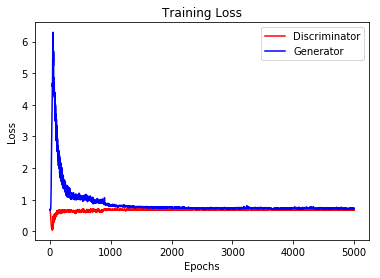

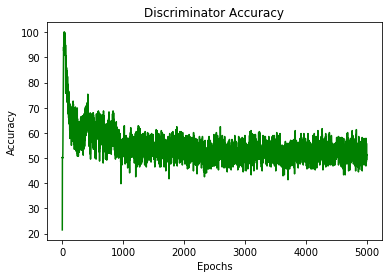

In [0]:
latent_dim, fake_ground_truth = 100, 0
epochs, batch_size, sample_interval = 5000, 128, 400
cgan = CGAN(X, y, latent_dim, fake_ground_truth)
cgan.train(epochs, batch_size, sample_interval)

### Observations:
1.   The predictive accuracy of the *discriminator* approaches ***0.5*** indicating that the generated images are intintinguishable from the real images.
2.   The (*binary cross-entropy*) loss of the *generator* as well as the  loss of the *discriminator*, approach *-log(0.5)*=***0.69*** (indicating equilibrium)

### Generate fake data with trained CGAN

In [0]:
def getFakeData(cgan, n, y, latent_dim):
  """returns n fake labeled images"""
  k = 0.5*255 # mean gray scale value
  classes, counts = np.unique(y, return_counts=True) # count of digits
  prop =  counts/sum(counts) # proportion of digits
  y_fake = np.random.choice(len(classes), size=n, p=prop)
  sampled_labels = y_fake.reshape(-1, 1)
  noise = np.random.normal(0, 1, (n, latent_dim))
  gen_imgs = cgan.generator.predict([noise, sampled_labels])
  gen_imgs = k + k*gen_imgs
  return gen_imgs.reshape(gen_imgs.shape[:-1]), y_fake

In [0]:
# generate the same number of fake labeled images as in the training set
X_fake, y_fake = getFakeData(cgan, len(y), y, latent_dim)

### Compare class distribution in real and generated images.

In [0]:
def digit_distribution(y, y_fake):
  """Compares distribution of classes in real and fake data"""
  pd.options.display.float_format = '{:,.2f}'.format
  freq = pd.DataFrame(list(range(10)), columns=['digits'])
  freq['Proportion in given data'] = np.bincount(y)/len(y)
  freq['Proportion in fake data'] = np.bincount(y_fake)/len(y_fake)
  return freq

In [0]:
# class distribution in the real fake images
digit_distribution(y, y_fake)

,digits,Proportion in given data,Proportion in fake data
0,0,0.10,0.10
1,1,0.11,0.11
2,2,0.10,0.10
3,3,0.10,0.10
4,4,0.10,0.10
5,5,0.09,0.09
6,6,0.10,0.10
7,7,0.10,0.11
8,8,0.10,0.10
9,9,0.10,0.10


### Display real and generated digits

In [0]:
def displayDigits(images, labels, nCols):
  """Displays images with labels (nCols per row)
  - images: list of vectors with 784 (28x28) grayscale values
  - labels: list of digits represented by images"""
  nRows = np.ceil(len(labels)/nCols).astype('int') # number of rows
  plt.figure(figsize=(2*nCols,2*nRows)) # figure size
  for i in range(len(labels)):
    plt.subplot(nRows,nCols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
    plt.xlabel(str(labels[i]), fontsize=14)
  plt.show()
  return

In [0]:
def plot_mean_image(num_classes, X, y, header):
  print("Plot of mean values of %s" %header)
  labels = list(range(num_classes))
  images = [np.mean(X[np.where(y == d)], axis=0) for d in labels]
  displayDigits(images, labels, nCols=5)
  
  

Plot of mean values of real images


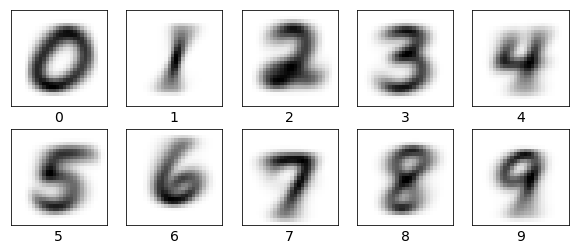

In [0]:
plot_mean_image(10, X, y, "real images")

Plot of mean values of fake images


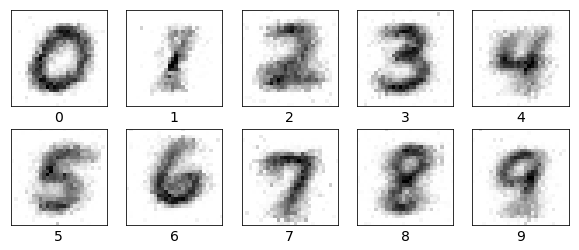

In [0]:
plot_mean_image(10, X_fake, y_fake, "fake images")

### Specify model for digit recognition

In [0]:
# Define tensorflow convolution neural network (CNN)
def cnn():
    model = Sequential() # create model
    # first convolution layer
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=(28,28, 1)))
    model.add(MaxPooling2D(pool_size=(2,2))) # max pooling
    # second convolution layer
    model.add(Conv2D(64, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2))) # max pooling
    model.add(Dropout(0.2)) # dropout layer
    model.add(Flatten()) # flatten for densely connected layer
    model.add(Dense(256, activation='relu')) # dense layer
    model.add(Dropout(0.2)) # dropout layer
    model.add(Dense(10, activation='softmax')) # softmax layer
    model.compile(loss=categorical_crossentropy,
                  optimizer=Adadelta(),
                  metrics=['accuracy'])
    return model
  


In [0]:
model = cnn()
print(model.summary()) # display model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 256)               262400    
__________

In [0]:
# function to plot training and validation accuracy
def plotHistory(modelName, history, start=0):
    """Plots training and validation accuracy"""
    plt.plot(history.history['acc'][start:])
    plt.plot(history.history['val_acc'][start:])
    plt.title(modelName+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def Xform(x):
    """function to reshape CNN inputs"""
    return x.reshape(len(x), 28, 28, 1)/255

### Train and test model with real (original data)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 5s 94us/step - loss: 0.2539 - acc: 0.9195 - val_loss: 0.0689 - val_acc: 0.9788
Epoch 2/10
50000/50000 [==============================] - 3s 52us/step - loss: 0.0675 - acc: 0.9790 - val_loss: 0.0446 - val_acc: 0.9878
Epoch 3/10
50000/50000 [==============================] - 3s 52us/step - loss: 0.0459 - acc: 0.9859 - val_loss: 0.0395 - val_acc: 0.9875
Epoch 4/10
50000/50000 [==============================] - 3s 52us/step - loss: 0.0365 - acc: 0.9888 - val_loss: 0.0346 - val_acc: 0.9901
Epoch 5/10
50000/50000 [==============================] - 3s 52us/step - loss: 0.0313 - acc: 0.9901 - val_loss: 0.0395 - val_acc: 0.9898
Epoch 6/10
50000/50000 [==============================] - 3s 52us/step - loss: 0.0265 - acc: 0.9914 - val_loss: 0.0297 - val_acc: 0.9908
Epoch 7/10
50000/50000 [==============================] - 3s 51us/step - loss: 0.0215 - acc: 0.9932 - val_loss: 0.0297 - val_acc

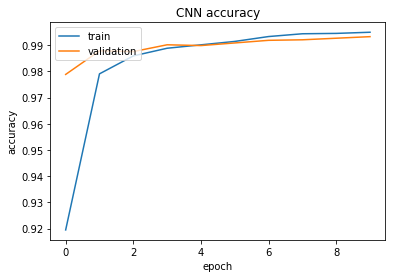


Accuracy with test data = 99.40%

Confusion matrix:


Accuracy with test data = 99.40%

Confusion matrix:



,0,1,2,3,4,5,6,7,8,9
0,975,0,1,0,0,0,1,2,1,0
1,0,1132,0,0,0,1,1,1,0,0
2,1,1,1028,0,0,0,0,2,0,0
3,0,0,1,1005,0,2,0,0,2,0
4,0,0,0,0,981,0,0,0,0,1
5,1,0,0,3,0,883,2,1,1,1
6,3,2,0,0,1,1,950,0,1,0
7,0,3,2,1,0,0,0,1020,1,1
8,2,0,1,0,0,0,0,0,971,0
9,1,0,0,1,7,3,0,2,0,995


In [0]:
model = cnn()
history = model.fit(Xform(X), to_categorical(y, 10),
                    validation_split=1/6, batch_size=128, epochs=10)
plotHistory("CNN", history, start=0)
predicted = model.predict(Xform(X_test)).argmax(axis=1) # predict test labels 
acc = accuracy_score(y_test, predicted) # accuracy with test data
print("\nAccuracy with test data = %4.2f%%\n" %(acc*100))

print("Confusion matrix:\n")
pd.DataFrame(confusion_matrix(y_test, predicted)) # display confusion matrix
acc = accuracy_score(y_test, predicted) # accuracy with test data
print("\nAccuracy with test data = %4.2f%%\n" %(acc*100))

print("Confusion matrix:\n")
pd.DataFrame(confusion_matrix(y_test, predicted)) # display confusion matrix

### Train and test model with fake (generated data)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 97us/step - loss: 0.1774 - acc: 0.9442 - val_loss: 0.0275 - val_acc: 0.9921
Epoch 2/20
50000/50000 [==============================] - 2s 49us/step - loss: 0.0309 - acc: 0.9901 - val_loss: 0.0198 - val_acc: 0.9932
Epoch 3/20
50000/50000 [==============================] - 2s 49us/step - loss: 0.0202 - acc: 0.9939 - val_loss: 0.0145 - val_acc: 0.9950
Epoch 4/20
50000/50000 [==============================] - 2s 49us/step - loss: 0.0158 - acc: 0.9952 - val_loss: 0.0134 - val_acc: 0.9956
Epoch 5/20
50000/50000 [==============================] - 2s 49us/step - loss: 0.0128 - acc: 0.9958 - val_loss: 0.0118 - val_acc: 0.9966
Epoch 6/20
50000/50000 [==============================] - 2s 49us/step - loss: 0.0107 - acc: 0.9969 - val_loss: 0.0107 - val_acc: 0.9963
Epoch 7/20
50000/50000 [==============================] - 2s 49us/step - loss: 0.0097 - acc: 0.9969 - val_loss: 0.0100 - val_acc

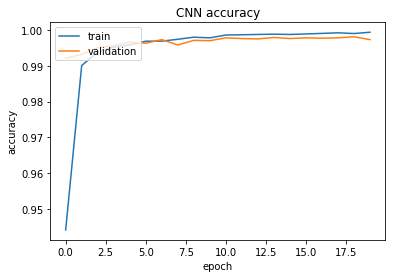


Accuracy with test data = 93.27%

Confusion matrix:



,0,1,2,3,4,5,6,7,8,9
0,963,0,1,9,0,3,1,1,1,1
1,0,1105,2,13,0,4,3,3,4,1
2,8,1,951,20,3,2,0,33,14,0
3,5,0,10,962,1,12,0,7,6,7
4,1,0,6,1,927,0,3,2,3,39
5,3,0,2,44,0,825,3,3,11,1
6,27,1,3,5,6,44,868,0,4,0
7,2,4,27,4,3,1,0,966,0,21
8,3,1,3,56,4,40,3,17,825,22
9,17,4,7,15,10,1,0,16,4,935


In [0]:
model = cnn()
history = model.fit(Xform(X_fake), to_categorical(y_fake, 10),
                    validation_split=1/6, batch_size=128, epochs=20)
plotHistory("CNN", history, start=0)
predicted = model.predict(Xform(X_test)).argmax(axis=1) # predict test labels 
acc = accuracy_score(y_test, predicted) # accuracy with test data
print("\nAccuracy with test data = %4.2f%%\n" %(acc*100))

print("Confusion matrix:\n")
pd.DataFrame(confusion_matrix(y_test, predicted)) # display confusion matrix

***Turing Test***: Can the quality of the generated labeled images be improved so that a model trained on it can achieve the same classification accuract with the test data as a model trained on real data?